In [1]:
import matplotlib.pyplot as plt
import env
import seaborn as sns
import pandas as pd 
import wrangle
from sklearn.model_selection import train_test_split
import scipy.stats as stats

def get_connection(db, user=env.user, host=env.host, password=env.password):
    '''initiates sql connection'''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'
    
#pulling from the code up server the zillow data frame   
def sqlclean_zillow():
    query = '''
    SELECT
    prop.*,
    predictions_2017.logerror,
    predictions_2017.transactiondate,
    air.airconditioningdesc,
    arch.architecturalstyledesc,
    build.buildingclassdesc,
    heat.heatingorsystemdesc,
    landuse.propertylandusedesc,
    story.storydesc,
    calculatedfinishedsquarefeet,
    construct.typeconstructiondesc
    FROM properties_2017 prop
    JOIN (
    SELECT parcelid, MAX(transactiondate) AS max_transactiondate
    FROM predictions_2017
    GROUP BY parcelid
    ) pred USING(parcelid)
    JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid
    AND pred.max_transactiondate = predictions_2017.transactiondate
    LEFT JOIN airconditioningtype air USING (airconditioningtypeid)
    LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid)
    LEFT JOIN buildingclasstype build USING (buildingclasstypeid)
    LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid)
    LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid)
    LEFT JOIN storytype story USING (storytypeid)
    LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid)
    WHERE prop.latitude IS NOT NULL
    AND prop.longitude IS NOT NULL
    AND transactiondate <= '2017-12-31' '''

    url = f"mysql+pymysql://{env.user}:{env.password}@{env.host}/zillow"
    df = pd.read_sql(query,url)

    return df
def get_upper_outliers(s, k):
    '''
    Given a series and a cutoff value, k, returns the upper outliers for the
    series.

    The values returned will be either 0 (if the point is not an outlier), or a
    number that indicates how far away from the upper bound the observation is.
    '''
    q1, q3 = s.quantile([.25, .75])
    iqr = q3 - q1
    upper_bound = q3 + k * iqr
    return s.apply(lambda x: max([x - upper_bound, 0]))

def add_upper_outlier_columns(df, k):
    '''
    Add a column with the suffix _outliers for all the numeric columns
    in the given dataframe.
    '''
    # outlier_cols = {col + '_outliers': get_upper_outliers(df[col], k)
    #                 for col in df.select_dtypes('number')}
    # return df.assign(**outlier_cols)

    for col in df.select_dtypes('number'):
        df[col + '_outliers'] = get_upper_outliers(df[col], k)

    return df

def my_train_test_split(df):
    '''
    Takes in a dataframe and target (as a string). Returns train, validate, and test subset 
    dataframes with the .2/.8 and .25/.75 splits to create a final .2/.2/.6 split between datasets
    '''
    train, test = train_test_split(df, test_size = .2, random_state=123)
    train, validate = train_test_split(train, test_size = .25, random_state=123,)
    
    return train, validate, test
def my_train_test_split1(df, target):
    '''
    Takes in a dataframe and target (as a string). Returns train, validate, and test subset 
    dataframes with the .2/.8 and .25/.75 splits to create a final .2/.2/.6 split between datasets
    '''
    train, test = train_test_split(df, test_size = .2, random_state=123, stratify=df[target])
    train, validate = train_test_split(train, test_size = .25, random_state=123, stratify=train[target])
    
    return train, validate, test

# Exercises

Sourcing the Zillow database as the data source, create a jupyter notebook named explore_zillow and do the following:

1)Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

2)Answer those questions through a mix of statistical tests and visualizations.
Bonus:

bonus)Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.

In [2]:
df = sqlclean_zillow()

In [3]:
df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,calculatedfinishedsquarefeet,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,0.025595,2017-01-01,None,None,None,None,Single Family Residential,None,3100.0,None
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,...,0.055619,2017-01-01,None,None,None,None,Single Family Residential,None,1465.0,None
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,...,0.005383,2017-01-01,None,None,None,None,Single Family Residential,None,1243.0,None
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,...,-0.103410,2017-01-01,None,None,None,Central,Single Family Residential,None,2376.0,None
4,1970746,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,...,0.006940,2017-01-01,Central,None,None,Central,Condominium,None,1312.0,None


In [9]:
df=wrangle.handle_missing_values(df, prop_required_column=1, prop_required_row=0)

In [10]:
df.columns

Index(['id', 'parcelid', 'bathroomcnt', 'bedroomcnt', 'fips', 'latitude',
       'longitude', 'propertycountylandusecode', 'propertylandusetypeid',
       'rawcensustractandblock', 'regionidcounty', 'roomcnt', 'assessmentyear',
       'logerror', 'transactiondate', 'propertylandusedesc'],
      dtype='object')

In [11]:
train, validate, test = my_train_test_split(df)
train.shape,validate.shape,test.shape

((46428, 16), (15476, 16), (15476, 16))

In [12]:
train['county'] = train.fips.apply(lambda x: 'orange' if x == 6059.0 else 'los_angeles' if x == 6037.0 else 'ventura')


In [13]:
train.head()

,id,parcelid,bathroomcnt,bedroomcnt,fips,latitude,longitude,propertycountylandusecode,propertylandusetypeid,rawcensustractandblock,regionidcounty,roomcnt,assessmentyear,logerror,transactiondate,propertylandusedesc,county
44100,534463,14362433,2.0,2.0,6059.0,33690163.0,-117667260.0,122,261.0,6.059052e+07,1286.0,0.0,2016.0,0.007853,2017-06-07,Single Family Residential,orange
66883,1470283,12733749,2.0,3.0,6037.0,33916507.0,-117983847.0,0100,261.0,6.037504e+07,3101.0,0.0,2016.0,0.004492,2017-08-16,Single Family Residential,los_angeles
52746,2975566,12601481,1.0,1.0,6037.0,33830200.0,-118344000.0,010F,267.0,6.037651e+07,3101.0,0.0,2016.0,0.044677,2017-06-30,Cooperative,los_angeles
52116,761911,10755382,3.0,4.0,6037.0,34137942.0,-118659484.0,010D,269.0,6.037800e+07,3101.0,0.0,2016.0,-0.030104,2017-06-30,Planned Unit Development,los_angeles
22934,1126077,12451385,2.0,3.0,6037.0,33863953.0,-118168429.0,0100,261.0,6.037571e+07,3101.0,0.0,2016.0,0.040685,2017-04-03,Single Family Residential,los_angeles


# 1)Ask at least 5 questions about the data, keeping in mind that your target variable is logerror. e.g. Is logerror significantly different for properties in LA County vs Orange County vs Ventura County?

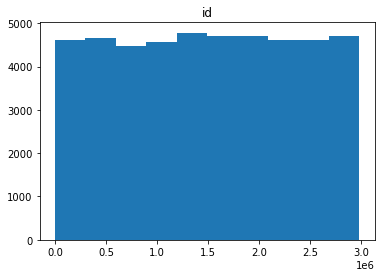

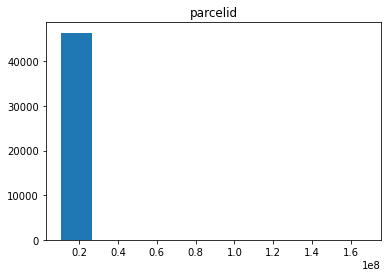

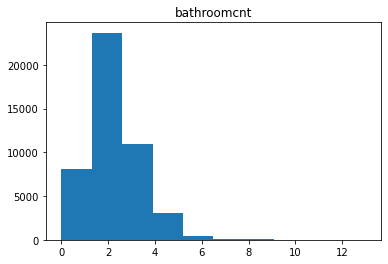

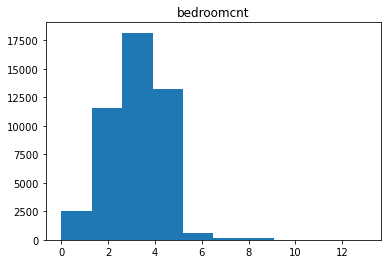

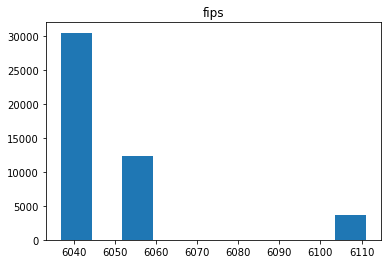

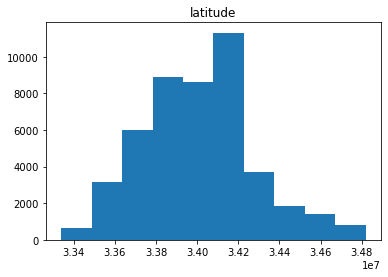

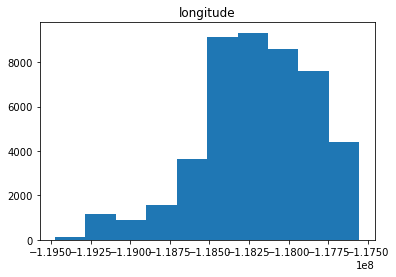

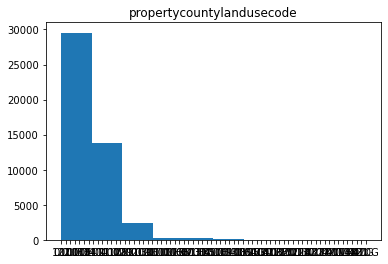

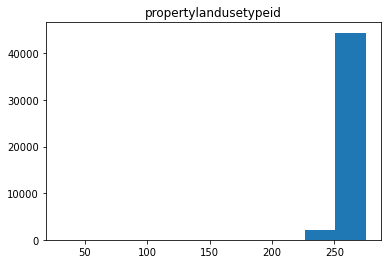

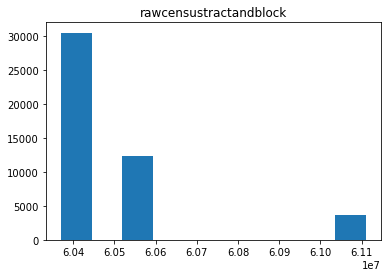

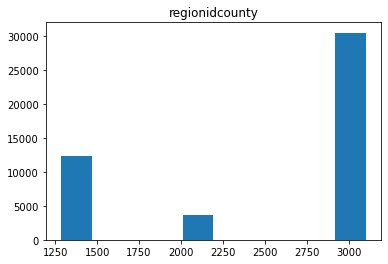

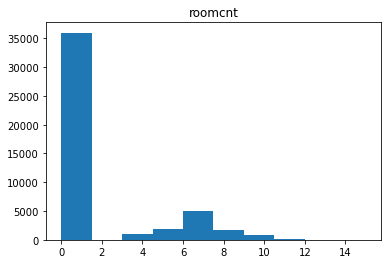

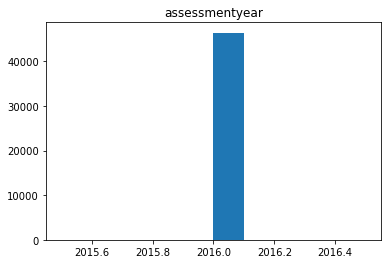

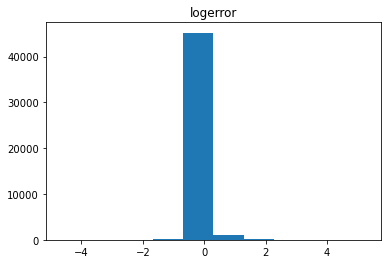

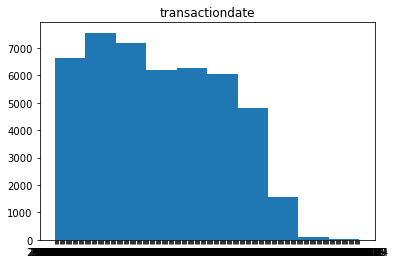

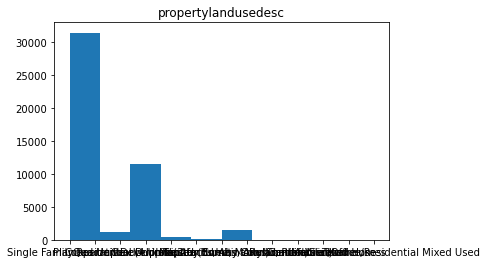

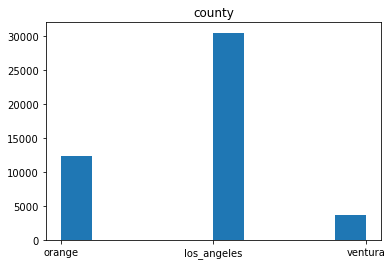

In [14]:
for col in train.columns:
    plt.hist(train[col])
    plt.title(col)
    plt.show()

In [15]:
train.head()

,id,parcelid,bathroomcnt,bedroomcnt,fips,latitude,longitude,propertycountylandusecode,propertylandusetypeid,rawcensustractandblock,regionidcounty,roomcnt,assessmentyear,logerror,transactiondate,propertylandusedesc,county
44100,534463,14362433,2.0,2.0,6059.0,33690163.0,-117667260.0,122,261.0,6.059052e+07,1286.0,0.0,2016.0,0.007853,2017-06-07,Single Family Residential,orange
66883,1470283,12733749,2.0,3.0,6037.0,33916507.0,-117983847.0,0100,261.0,6.037504e+07,3101.0,0.0,2016.0,0.004492,2017-08-16,Single Family Residential,los_angeles
52746,2975566,12601481,1.0,1.0,6037.0,33830200.0,-118344000.0,010F,267.0,6.037651e+07,3101.0,0.0,2016.0,0.044677,2017-06-30,Cooperative,los_angeles
52116,761911,10755382,3.0,4.0,6037.0,34137942.0,-118659484.0,010D,269.0,6.037800e+07,3101.0,0.0,2016.0,-0.030104,2017-06-30,Planned Unit Development,los_angeles
22934,1126077,12451385,2.0,3.0,6037.0,33863953.0,-118168429.0,0100,261.0,6.037571e+07,3101.0,0.0,2016.0,0.040685,2017-04-03,Single Family Residential,los_angeles


<AxesSubplot:xlabel='latitude', ylabel='longitude'>

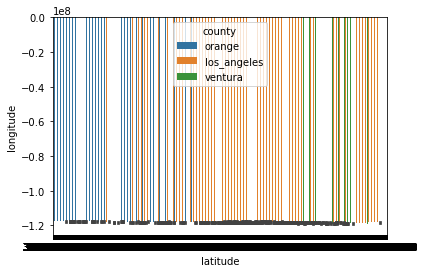

In [16]:
sns.barplot(data=train,x='latitude',y='longitude',hue='county')
#the whole rainbow !!!

# 1)los angelos compared between  orange to logerror

/opt/homebrew/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


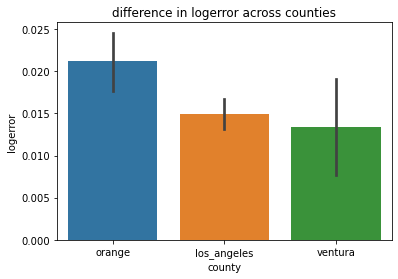

In [17]:
#orange has the highest logerror out of all of them aka countys
sns.barplot(train.county, train.logerror)
plt.title('difference in logerror across counties')
plt.show()

In [18]:
stats.levene(train[train.county == 'los_angeles'].logerror, train[train.county == 'orange'].logerror)

LeveneResult(statistic=18.135881461667353, pvalue=2.0612773291045928e-05)

In [19]:
stats.ttest_ind(train[train.county == 'los_angeles'].logerror, train[train.county == 'orange'].logerror, equal_var=False)
# Reject the null hypothesis and suggest there is significant difference 
# between means of logerror between orange and Los Angeles Counties

Ttest_indResult(statistic=-3.109474527773958, pvalue=0.0018769297315213217)

# 2)ventura compared between  orange to logerror

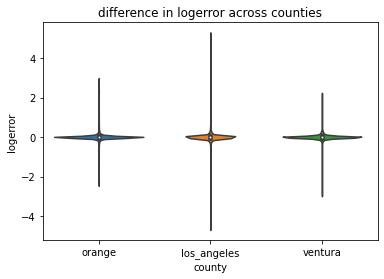

In [20]:
#orange has the highest logerror out of all of them aka countys
sns.violinplot(data=train,x=train.county, y=train.logerror)
plt.title('difference in logerror across counties')
plt.show()

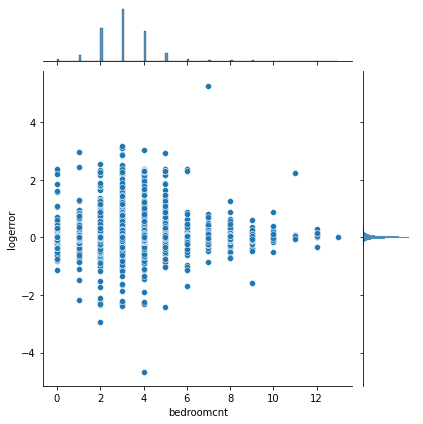

In [21]:
sns.jointplot(x='bedroomcnt', y='logerror', data=train)
plt.xlabel('Calculated bed rooms')
plt.ylabel('Logerror')
plt.show()

In [22]:
stats.levene(train[train.county == 'ventura'].logerror, train[train.county == 'orange'].logerror)

LeveneResult(statistic=0.29077944061317507, pvalue=0.5897289900880067)

In [23]:
stats.ttest_ind(train[train.county == 'ventura'].logerror, train[train.county == 'orange'].logerror, equal_var=False)
# Reject the null hypothesis and suggest there is significant difference 
# between means of logerror between orange and Los Angeles Counties

Ttest_indResult(statistic=-2.332460851131689, pvalue=0.019704642012270526)

### theres a little difference between ventura and orange logerror

# 3)bedrooms compared to logerror:

Relationship between bed rooms and Logerror?


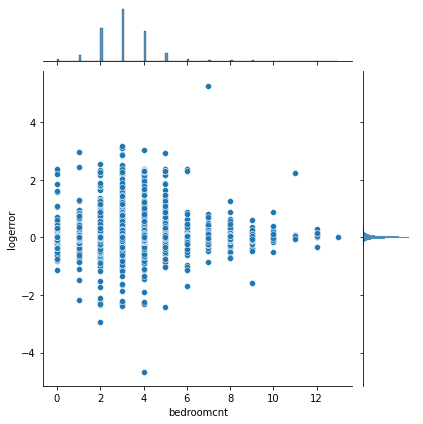

In [24]:
print('Relationship between bed rooms and Logerror?')
sns.jointplot(x='bedroomcnt', y='logerror', data=train)
plt.xlabel('Calculated bed rooms')
plt.ylabel('Logerror')
plt.show()

In [25]:
# H0: Variance in logerror for homes with 6 or less bedrooms is equivalent to those with more than 6 bedrooms
# alpha of 0.05
stats.levene(train[train.bedroomcnt > 6].logerror, train[train.bedroomcnt <= 6].logerror)

LeveneResult(statistic=99.25703510671926, pvalue=2.3408129158072442e-23)

### takeaways: homes with 6 of more bedrooms arent the same as homes with 5 or less bed rooms

# 4)bathrooms compared to logerror:


Relationship between bathrooms and Logerror?


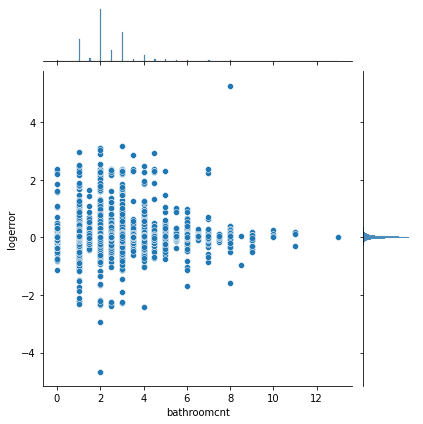

In [26]:
print('Relationship between bathrooms and Logerror?')
sns.jointplot(x='bathroomcnt', y='logerror', data=train)
plt.xlabel('Calculated bathrooms')
plt.ylabel('Logerror')
plt.show()

In [27]:
# H0: Variance in logerror for homes with 6 or less bedrooms is equivalent to those with more than 6 bedrooms
# alpha of 0.05
stats.levene(train[train.bathroomcnt > 6].logerror, train[train.bathroomcnt <= 6].logerror)

LeveneResult(statistic=85.0693589304162, pvalue=2.9978693594216555e-20)

### takeaways :homes with 6 of more bathrooms arent the same as homes with 5 or less bathroooms

# 5)Does latitude&longitude effect logerror?

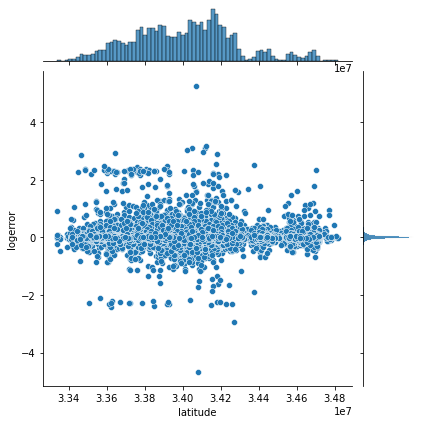

In [28]:
sns.jointplot(x='latitude', y='logerror', data=train)
plt.xlabel('Calculated bathrooms')
plt.ylabel('Logerror')
plt.show()

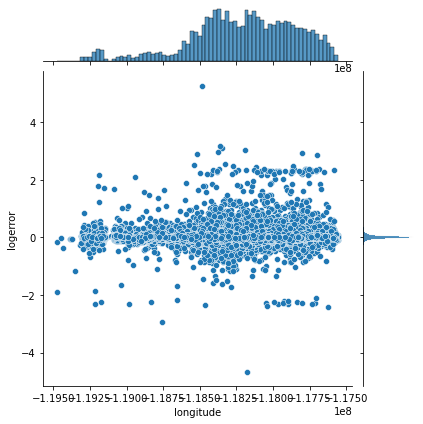

In [29]:
sns.jointplot(x='longitude', y='logerror', data=train)
plt.xlabel('Calculated bathrooms')
plt.ylabel('Logerror')
plt.show()

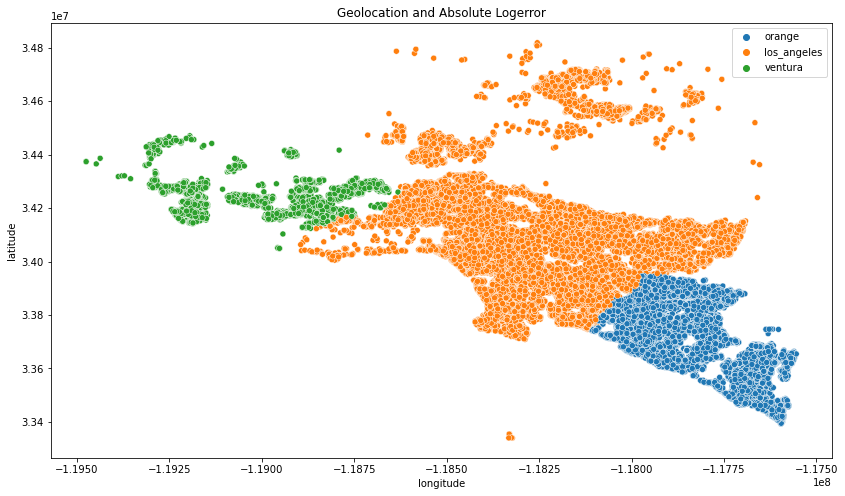

In [30]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='longitude', y='latitude', hue='county', sizes=(0,300), data=train)
plt.legend()
plt.title('Geolocation and Absolute Logerror')
plt.show()

# Bonus)Compute the mean(logerror) by zipcode and the overall mean(logerror). Write a loop that will run a t-test between the overall mean and the mean for each zip code. We want to identify the zip codes where the error is significantly higher or lower than the expected error.